### Load Data

In [1]:
# import some packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# load the data
df_2015 = pd.read_excel('2015.xlsx', sheet_name = 'FEguide')
df_2016 = pd.read_excel('2016.xlsx', sheet_name = 'FEguide')
df_2017 = pd.read_excel('2017.xlsx', sheet_name = 'FEguide')
df_2018 = pd.read_excel('2018.xlsx', sheet_name = 'FEguide')

In [3]:
#concat the data 
df_total = pd.concat([df_2015, df_2016, df_2017,df_2018])
print('Total df shape:',df_total.shape)

('Total df shape:', (4921, 162))


### Preprocessing: baseline feature selections

According to instructions on Piazza, delete certain features (FE, EPA, CO2, Guzzler...)


#### Features in doubt: 

Car/Truck Category - Cash for Clunkers Bill (many missing values, unclear about 1 and car, we may refer 1 is truck category)

Relabel (after label recalc, then divide the relabel once again). 
So logic goes this way: we include relabel, fill blank with 0, then one-hot encode it, and thus exclude label recalc.

Battery Type Desc, Total Voltage for Battery Pack(s), Batt Energy Capacity (Amp-hrs), Batt Specific Energy (Watt-hr/kg),Batt Charger Type Desc: 

Same as before, by setting blank as 0, we exclude # of batteries


Rated Motor Gen Power (kW): same as before, include this and exclude # Drive Motor Gen

Some adjust need: for example, 34,26,26 will be replaced by 86 as the sum of motor power

Off Board Charge Capable (Y or N): No idea how to adjust this column with only N and blank value

#### Features in doubt and exclude:

Carline: almost one row per category meaning less to encode that

Range1 - Model Type Driving Range - Conventional Fuel: Too much missing data, not informational


In [4]:
columns_to_keep = ['Model Year','Verify Mfr Cd','Eng Displ', '# Cyl', 'Transmission', 'Comb Unrd Adj FE - Conventional Fuel', 
                   'Air Aspir Method','# Gears','Lockup Torque Converter','Trans Creeper Gear',  
                    'Drive Sys','Max Ethanol % - Gasoline', 'Max Biodiesel %','Fuel Usage  - Conventional Fuel',
                   'Descriptor - Model Type (40 Char or less)','Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)',
                   'Annual Fuel1 Cost - Conventional Fuel','Intake Valves Per Cyl','Exhaust Valves Per Cyl','Carline Class', 'Car/Truck Category - Cash for Clunkers Bill.',
                   'Calc Approach Desc','Unique Label?','Label Recalc?','Relabel','Cyl Deact?','Var Valve Timing?','Var Valve Lift?',
                  'Battery Type Desc','Total Voltage for Battery Pack(s)','Batt Energy Capacity (Amp-hrs)',
                   'Batt Specific Energy (Watt-hr/kg)','Batt Charger Type Desc','Regen Braking Type Desc',
                    'Regen Braking Wheels Source (Front, Rear, Both)',
                  'Driver Cntrl Regen Braking?','Rated Motor Gen Power (kW)','Fuel Metering Sys Cd',
                  'Off Board Charge Capable (Y or N)','Camless Valvetrain (Y or N)','Oil Viscosity',
                  'Stop/Start System (Engine Management System) Code']

df_total = df_total[columns_to_keep]
print(df_total.shape)

(4921, 42)


In [5]:
df_total.dtypes

Model Year                                                          int64
Verify Mfr Cd                                                      object
Eng Displ                                                         float64
# Cyl                                                               int64
Transmission                                                       object
Comb Unrd Adj FE - Conventional Fuel                              float64
Air Aspir Method                                                   object
# Gears                                                             int64
Lockup Torque Converter                                            object
Trans Creeper Gear                                                 object
Drive Sys                                                          object
Max Ethanol % - Gasoline                                          float64
Max Biodiesel %                                                   float64
Fuel Usage  - Conventional Fuel       

### Preprocessing: cleaning steps

#### Specific features need further imputation and adjust 

Model Year: after cleaning complete, split into train and test by year

Verify Mfr Cd: categorical

Transmission: categorical

Air Aspir Method: categorical with missing values

Lockup Torque Converter: binary, Y->1, N->0

Drive Sys: categorical

Max Ethanol % - Gasoline: discrete, replace blank with 0

Max Biodiesel %: discrete，replace blank with 0

Descriptor - Model Type (40 Char or less): fill balnk with no desc, categorical

Fuel Usage  - Conventional Fuel: categorical

Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition): binary, N-> 0, T->1

Carline Class: categorical

*** Car/Truck Category - Cash for Clunkers Bill.: very problematic, don't know how to deal with it, we may infer it's categorical (not binary); 1 for special type minivan, ?? for special tyoe, car for car and blank for truck

Calc Approach Desc: categorical

Unique Label?: N --> 0, Y -->1, with around 10% missing values

Label Recalc?: categorical, mod, N and Y, with around 5% missing values

Relabel: blanks for no relabel

Cyl Deact?: binary

Var Valve Timing?: binary

Var Valve Lift?: binary

Battery Type Desc: categorical, blanks for no battery

Total Voltage for Battery Pack(s): discrete, blanks for 0

Batt Energy Capacity (Amp-hrs): discrete, blanks for 0; one obvious outlier 1100(drop it)

Batt Specific Energy (Watt-hr/kg): discrete, blanks for 0

Batt Charger Type Desc: categorical, blanks for no battery; one obvious outlier 6 (drop it)

Regen Braking Type Desc: categorical, blanks for no regen braking

Regen Braking Wheels Source (Front, Rear, Both): blank for none wheels source

Driver Cntrl Regen Braking?: categorical, blank for none driver center 
May need to drop duplicates after one-hot encoding

*** Rated Motor Gen Power (kW): discrete, need to sum up the values, eg replace '76 and 86' with 162

Fuel Metering Sys Cd: categorical

Off Board Charge Capable (Y or N): categorical, blanks maybe for onboard

Camless Valvetrain (Y or N): binary

*** Oil Viscosity： this one gotta be crazy... after some research, these oil is not 
ordinal, but we need to summarize some feature; eg 5W-30 and 5w/30 are both 5W30
use pandas unique to adjust later

Stop/Start System (Engine Management System) Code: binary

#### Fillna + Feature Engineering

In [6]:
#fill missing values for some very certain features

df_total['Air Aspir Method'] = df_total['Air Aspir Method'].fillna(value='NA')
df_total['Max Ethanol % - Gasoline'] = df_total['Max Ethanol % - Gasoline'].fillna(0)
df_total['Max Biodiesel %'] = df_total['Max Biodiesel %'].fillna(0)
df_total['Car/Truck Category - Cash for Clunkers Bill.'] = df_total['Car/Truck Category - Cash for Clunkers Bill.'].fillna(value='truck')
df_total['Relabel'] = df_total['Relabel'].fillna(value='Not Relabelled')
df_total['Battery Type Desc'] = df_total['Battery Type Desc'].fillna(value='No battery')
df_total['Total Voltage for Battery Pack(s)'] = df_total['Total Voltage for Battery Pack(s)'].fillna(0)
df_total['Batt Energy Capacity (Amp-hrs)'] = df_total['Batt Energy Capacity (Amp-hrs)'].fillna(0)
df_total['Batt Specific Energy (Watt-hr/kg)'] = df_total['Batt Specific Energy (Watt-hr/kg)'].fillna(0)
df_total['Batt Charger Type Desc'] = df_total['Batt Charger Type Desc'].fillna(value = 'No batt charger')
df_total['Regen Braking Type Desc'] = df_total['Regen Braking Type Desc'].fillna(value='Not Regen braking')
df_total['Regen Braking Wheels Source (Front, Rear, Both)'] = df_total['Regen Braking Wheels Source (Front, Rear, Both)'].fillna(value='Not wheel source')
df_total['Driver Cntrl Regen Braking?'] = df_total['Driver Cntrl Regen Braking?'].fillna(value='No driver center')
df_total['Rated Motor Gen Power (kW)'] = df_total['Rated Motor Gen Power (kW)'].fillna(0)
df_total['Off Board Charge Capable (Y or N)'] = df_total['Off Board Charge Capable (Y or N)'].fillna(value='nonchargeable')
df_total['Descriptor - Model Type (40 Char or less)'] = df_total['Descriptor - Model Type (40 Char or less)'].fillna(value='no desc')


In [7]:
# fill missing values with some doubtable features, since they have like less than 10% missing value, try fillna with the most frequent values
df_total['Unique Label?']=df_total['Unique Label?'].fillna(df_total['Unique Label?'].value_counts().index[0])
df_total['Label Recalc?']=df_total['Label Recalc?'].fillna(df_total['Label Recalc?'].value_counts().index[0])

### Feature Engineering for data cleaning... (Maybe this should not be called feature engineering, but it's somewhat beyond the basic cleaning)

In [8]:
# adjust rated motor gen power, eg, 76 and 86 --> 162
df_total['Rated Motor Gen Power (kW)'].unique()

array([0, 15, 40, 17, 50, 18, 10, 28, 64, 124, 35, 24, 48, 20, 56,
       u'12 and 24', u'12 and 56', 34, u'35, 27, 27', u'76 and 86', 37,
       u'26, 26, 34', 120, 135, 32, 30, u'34, 26, 26', 38], dtype=object)

In [9]:
gen_power = {'12 and 24':36, 
             '12 and 56':68, 
             '35, 27, 27':89, 
             '76 and 86':162,
            '26, 26, 34':86,
            '34, 26, 26':86}
df_total['Rated Motor Gen Power (kW)'] = df_total['Rated Motor Gen Power (kW)'].replace(gen_power)

Special treatment on Oil Viscosity feature!

This categorical data really needs to be manully set into tidy categories.

In [10]:
#deal with the crazy Oil Viscosity feature
sorted(df_total['Oil Viscosity'].unique())

[u'0W-16',
 u'0W-20',
 u'0W-20 (ED6), 5W-20 (ED3)',
 u'0W-20 (ed6), 5w-20 (ed3)',
 u'0W-20 GF5',
 u'0W-20 VW50800',
 u'0W-20, GF-5',
 u'0W-30',
 u'0W-40',
 u'0W20',
 u'0W20 GF5',
 u'0W20 VW50400',
 u'0W30',
 u'0W30 ACEA C2',
 u'0W30 DC 225.26',
 u'0W30 GF4',
 u'0W30 VW 50400',
 u'0W30 VW50200 / VW50400',
 u'0W40',
 u'0W40 / API-SF/CD',
 u'0W40 / VW50200/VW50500',
 u'0W40 VW50200 / VW50500',
 u'0w-20',
 u'10W60',
 u'10W60 VW 50101 / 50500',
 u'5W-20',
 u'5W-20 AIP SM or ILSAC GF4',
 u'5W-20 GF-5',
 u'5W-20 GF4',
 u'5W-20 ILSAC GF-5',
 u'5W-20 or GF-4',
 u'5W-20, GF-5',
 u'5W-20/0W-20',
 u'5W-30',
 u'5W-30 ACEA A5',
 u'5W-30 DC225-11',
 u'5W-30 GF-5',
 u'5W-30 ILSAC GF-5',
 u'5W-30 and 0W-40',
 u'5W-30, GF-5',
 u'5W-30/dexos1',
 u'5W-30:IS 350C,0W-20:other',
 u'5W-40',
 u'5W-40 VW50200',
 u'5W-50',
 u'5W-50 GF-5',
 u'5W/30, VW50400',
 u'5W/40',
 u'5W20',
 u'5W20 ACEA A1/B1',
 u'5W20 API SM',
 u'5W20 API SM or ILSAC GF-4',
 u'5W20 API SM or ILSAC GF4',
 u'5W20 API or GF-4',
 u'5W20 API or

In [11]:
oil_type = {'0W-20':'0W20',
            'OW-20':'0W20',
            '0w-20':'0W20',
            '0W-20 (ed6), 5w-20 (ed3)':'0W-20 (ED6), 5W-20 (ED3)',
            '0W-20 GF5': '0W20 GF5',
             '0W-20, GF-5':'0W20 GF5',
            'GF-5 0W-20':'0W20 GF5',
            'GF-4 0W-20':'0W20 GF4',
            'GF-5 0W20':'0W20 GF5',
            '0W-20':'0W20',
             '0W-30':'0W30',
            '0W-40':'0W40',
            '0W40 / VW50200/VW50500': '0W40 VW50200/VW50500',
            '0W40 VW50200 / VW50500': '0W40 VW50200/VW50500',
            '5W-20':'5W20',
            '5W-20 AIP SM or ILSAC GF4':'5W20 API SM or ILSAC GF4',
            '5W20 API SM or ILSAC GF-4':'5W20 API SM or ILSAC GF4',
            '5W-20 GF-5':'5W20 GF5',
            '5W20 GF-5':'5W20 GF5',
            '5w-20 GF 5':'5W20 GF5',
            '5W-20, GF-5':'5W20 GF5',
            '5W20 GF 5':'5W20 GF5',
            '5W-20 GF4':'5W20 GF4',
            '5W20 GF-4':'5W20 GF4',
            '5W-20 ILSAC GF-5':'5W20 ILSAC GF5',
            '5W-30':'5W30',
           '5W-40':'5W40',
            '5W/40':'5W40',
            '5W-40 VW50200':'5W40 VW50200',
            '5W40 / VW50200':'5W40 VW50200',
            '5W40 VW 50200':'5W40 VW50200',
           '5W30 VW 504 00':'5W30 VW 50400',
           '5W30 GF-5':'5W30 GF5',
           '5w30 GF 5':'5W30 GF5',
           '5W30/ACEA A5':'5W30 ACEA A5',
           'SAE 5W-30':'SAE 5W30',
           '5W-30 ACEA A5':'5W30 ACEA A5',
           '5W-30, GF-5':'5W30, GF5',
           'SAE 5W-30 ACEA A5':'SAE 5W30 ACEA A5',
           'GF-5 5W-30':'5W30 GF5',
           '5w-30, GF 5':'5W30 GF5',
           '5W-30 GF-5':'5W30 GF5',
           'SAE5W-30':'SAE 5W30',
           'GF-4 5W-30':'5W30 GF4',
            'SAE 5W-20':'SAE 5W20'
           }

df_total['Oil Viscosity'] = df_total['Oil Viscosity'].replace(oil_type)

In [12]:
# For Drive Sys
drive_sys = {4:'Four'}
df_total['Drive Sys'] = df_total['Drive Sys'].replace(drive_sys)

### Drop obvious error data 

In [13]:
#Drop obvious error row
df_total = df_total[df_total['Batt Energy Capacity (Amp-hrs)']!=1100]
df_total = df_total[df_total['Batt Charger Type Desc']!=6]
df_total = df_total[df_total['Label Recalc?']!= 'Mod']
df_total.shape

(4914, 42)

### Set binary features

In [14]:
# To simplize, map binary features to 0, 1
df_total['Lockup Torque Converter'] = df_total['Lockup Torque Converter'].map(dict(Y=1, N=0))
df_total['Cyl Deact?'] = df_total['Cyl Deact?'].map(dict(Y=1, N=0))
df_total['Var Valve Timing?'] = df_total['Var Valve Timing?'].map(dict(Y=1, N=0))
df_total['Var Valve Lift?'] = df_total['Var Valve Lift?'].map(dict(Y=1, N=0))
df_total['Camless Valvetrain (Y or N)'] = df_total['Camless Valvetrain (Y or N)'].map(dict(Y=1, N=0))
df_total['Stop/Start System (Engine Management System) Code'] = df_total['Stop/Start System (Engine Management System) Code'].map(dict(Y=1, N=0))
df_total['Unique Label?'] = df_total['Unique Label?'].map(dict(Y=1, N=0))
df_total['Label Recalc?'] = df_total['Label Recalc?'].map(dict(Y=1, N=0))
df_total['Trans Creeper Gear'] = df_total['Trans Creeper Gear'].map(dict(Y=1, N=0))
df_total['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'] = df_total['Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)'].map(dict(T=1, N=0))

In [15]:
df_total.shape

(4914, 42)

### EDAV 

In [16]:
df_train = df_total[df_total['Model Year']!=2018]
df_test = df_total[df_total['Model Year']==2018]
X_train = df_train.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_train = df_train['Comb Unrd Adj FE - Conventional Fuel']
X_test = df_test.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_test = df_test['Comb Unrd Adj FE - Conventional Fuel']

#### First, show the distribution of y_train 

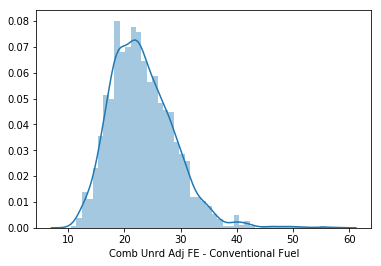

In [17]:
import seaborn as sns

sns.distplot(y_train)

#### Show countplot to explore categorical features

In [18]:
category_columns = ['Verify Mfr Cd',
                   'Transmission',
                   'Air Aspir Method',
                   'Drive Sys',
                   'Fuel Usage  - Conventional Fuel',
                    'Descriptor - Model Type (40 Char or less)',
                   'Carline Class',
                   'Car/Truck Category - Cash for Clunkers Bill.',
                   'Calc Approach Desc',
                   'Relabel',
                   'Battery Type Desc',
                   'Batt Charger Type Desc',
                   'Regen Braking Type Desc',
                   'Regen Braking Wheels Source (Front, Rear, Both)',
                   'Driver Cntrl Regen Braking?',
                   'Fuel Metering Sys Cd',
                   'Off Board Charge Capable (Y or N)',
                   'Oil Viscosity']
len(category_columns)

18

Text(0.5,0.98,u'Categorical Features')

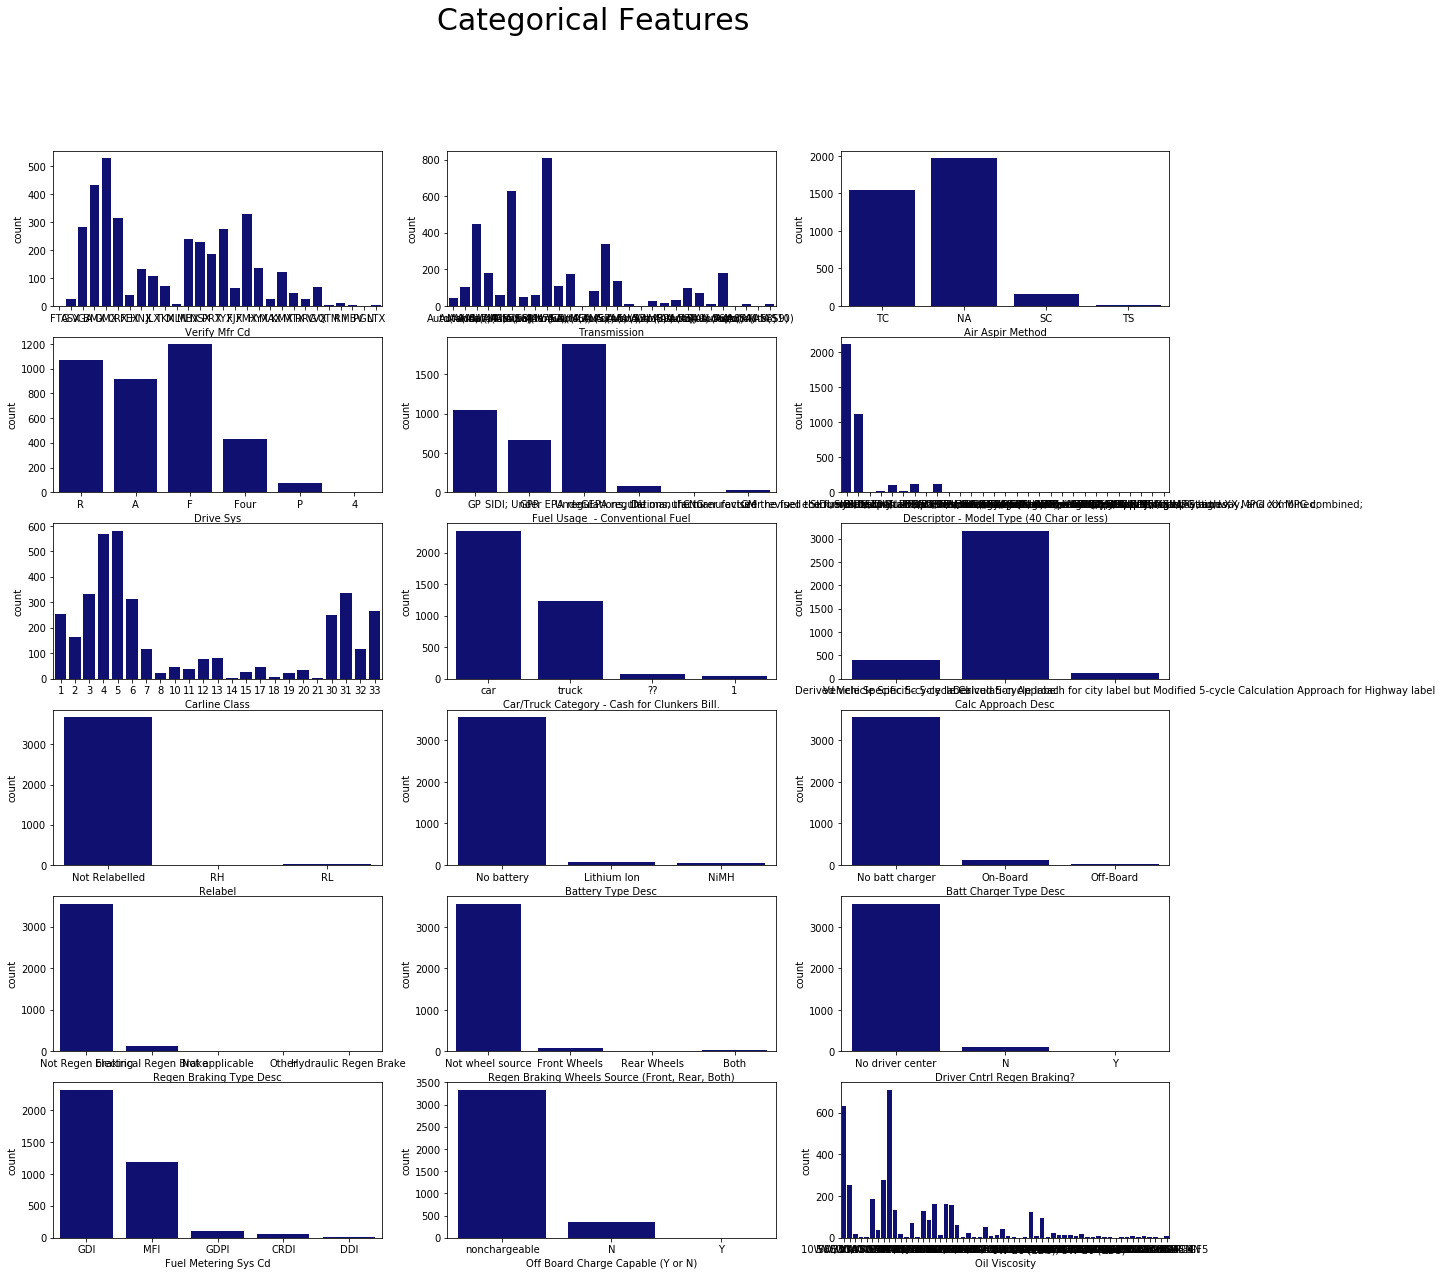

In [19]:
fig, axes = plt.subplots(6,3,figsize=(20,20))
k=0
for i in range(6):
    for j in range(3):
        sns.countplot(X_train[category_columns[k]],ax=axes[i,j],color='navy')
        k+=1
        
plt.suptitle("Categorical Features", fontsize=30)

#### Show countplot to explore binary features

In [19]:
binary_columns =['Lockup Torque Converter',
                'Cyl Deact?',
                'Var Valve Timing?',
                'Var Valve Lift?',
                'Camless Valvetrain (Y or N)',
                'Stop/Start System (Engine Management System) Code',
                'Unique Label?',
                'Label Recalc?',
                'Trans Creeper Gear',
                'Gas Guzzler Exempt (Where Truck = 1975 NHTSA truck definition)']
len(binary_columns)

10

Text(0.5,0.98,u'Binary Features')

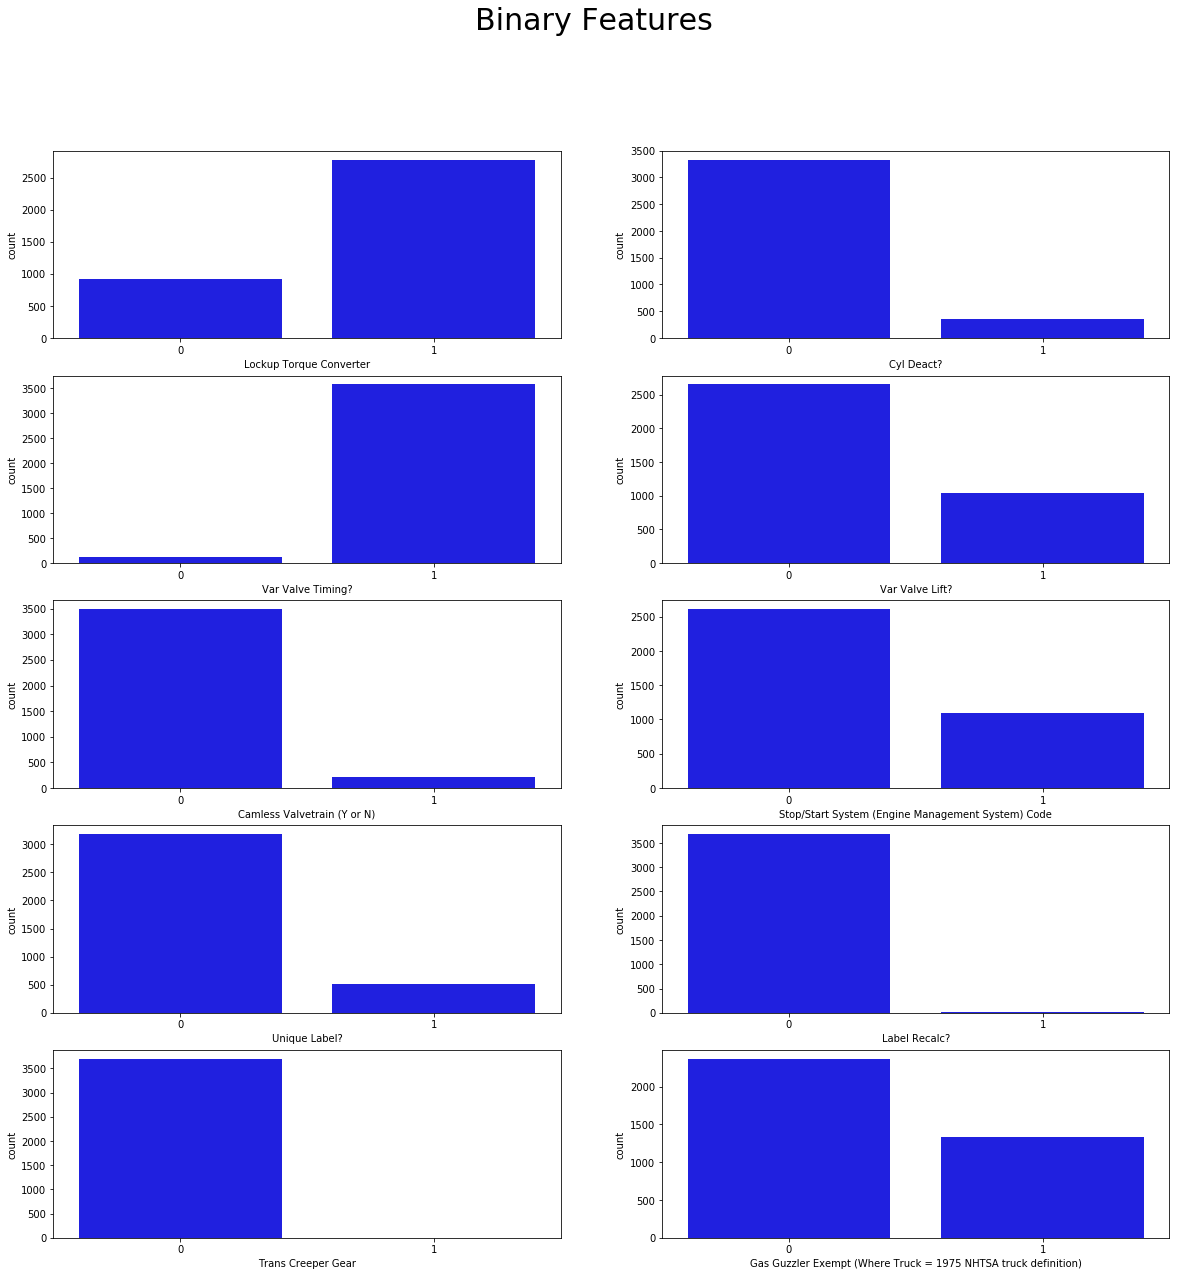

In [21]:
fig, axes = plt.subplots(5,2,figsize=(20,20))
k=0
for i in range(5):
    for j in range(2):
        sns.countplot(X_train[binary_columns[k]],ax=axes[i,j],color='blue')
        k+=1
        
plt.suptitle("Binary Features", fontsize=30)

### Show distplot to explore numerical features

In [20]:
numerical_columns = list(set(list(X_train)) - set(category_columns) -set(binary_columns))
len(numerical_columns)

13

Text(0.5,0.98,u'Numerical Features')

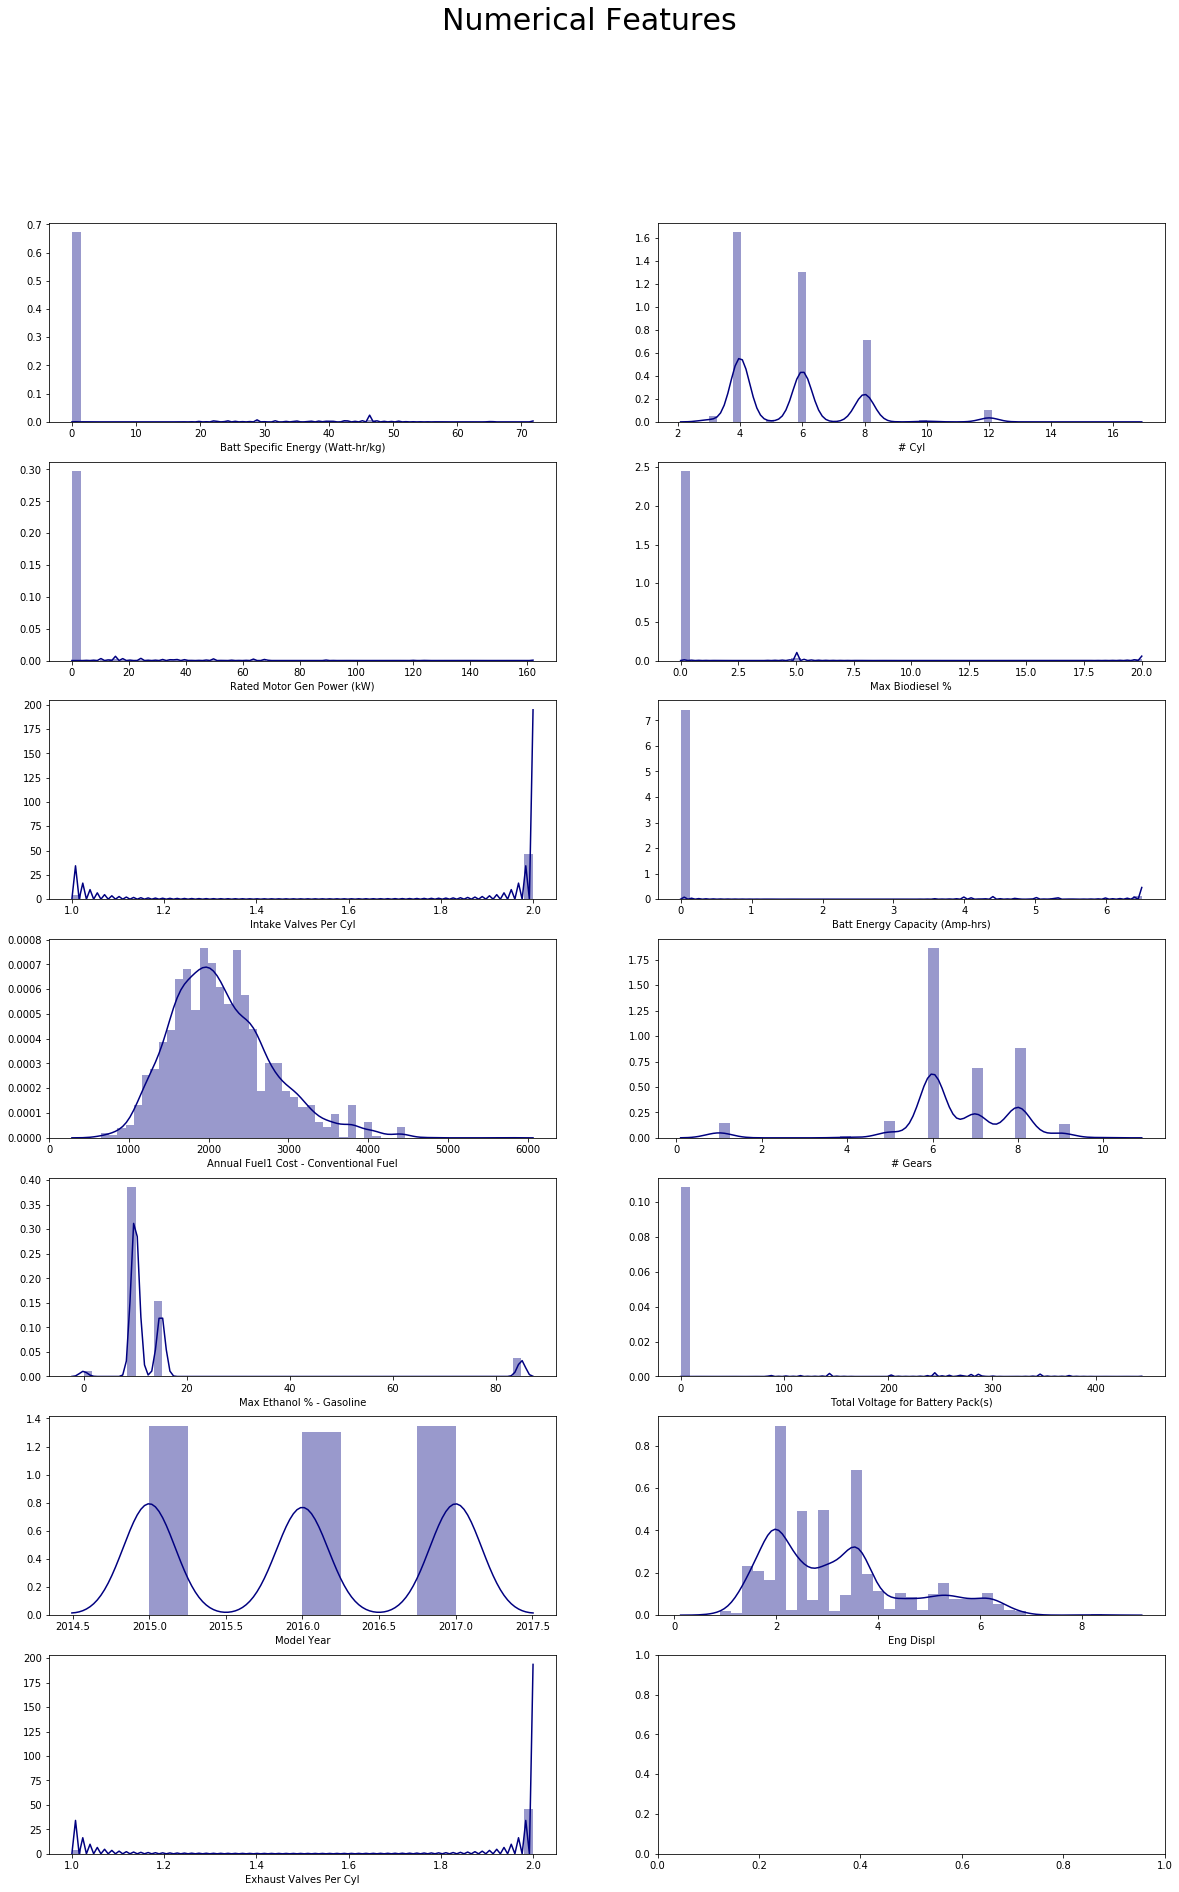

In [23]:
fig, axes = plt.subplots(7,2,figsize=(20,30))
k=0
for i in range(7):
    for j in range(2):
        sns.distplot(X_train[numerical_columns[k]],ax=axes[i,j],color='navy')
        k+=1
        if k==13:
            break
        
plt.suptitle("Numerical Features", fontsize=30)

### Get dummies for the categorical data and do basic step selection based on EDAV

In [21]:
df_total = pd.get_dummies(df_total, columns = category_columns)
df_total.shape

(4914, 256)

In [22]:
df_train = df_total[df_total['Model Year']!=2018]
df_test = df_total[df_total['Model Year']==2018]
X_train = df_train.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_train = df_train['Comb Unrd Adj FE - Conventional Fuel']
X_test = df_test.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_test = df_test['Comb Unrd Adj FE - Conventional Fuel']

In [23]:
X_train.shape, X_test.shape

((3694, 255), (1220, 255))

In [24]:
# Deal with
important_features = []
for i in list(X_train):
    if abs(y_train.corr(X_train[i]))>0.2:
        important_features.append(i)

In [25]:
len(important_features)

37

In [26]:
X_train=X_train[important_features]
X_test=X_test[important_features]

## Task 1 

### First try on a linear model

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print((lr.score(X_test, y_test)))

0.865179448104


This is our baseline score for the test set prediction. We will use this to check whether a model improves the behavior.

## Task 2 

Further EDAV needed!

In [28]:
len(list(X_train))

37

Text(0.5,0.98,u'Selected Features from Task 1')

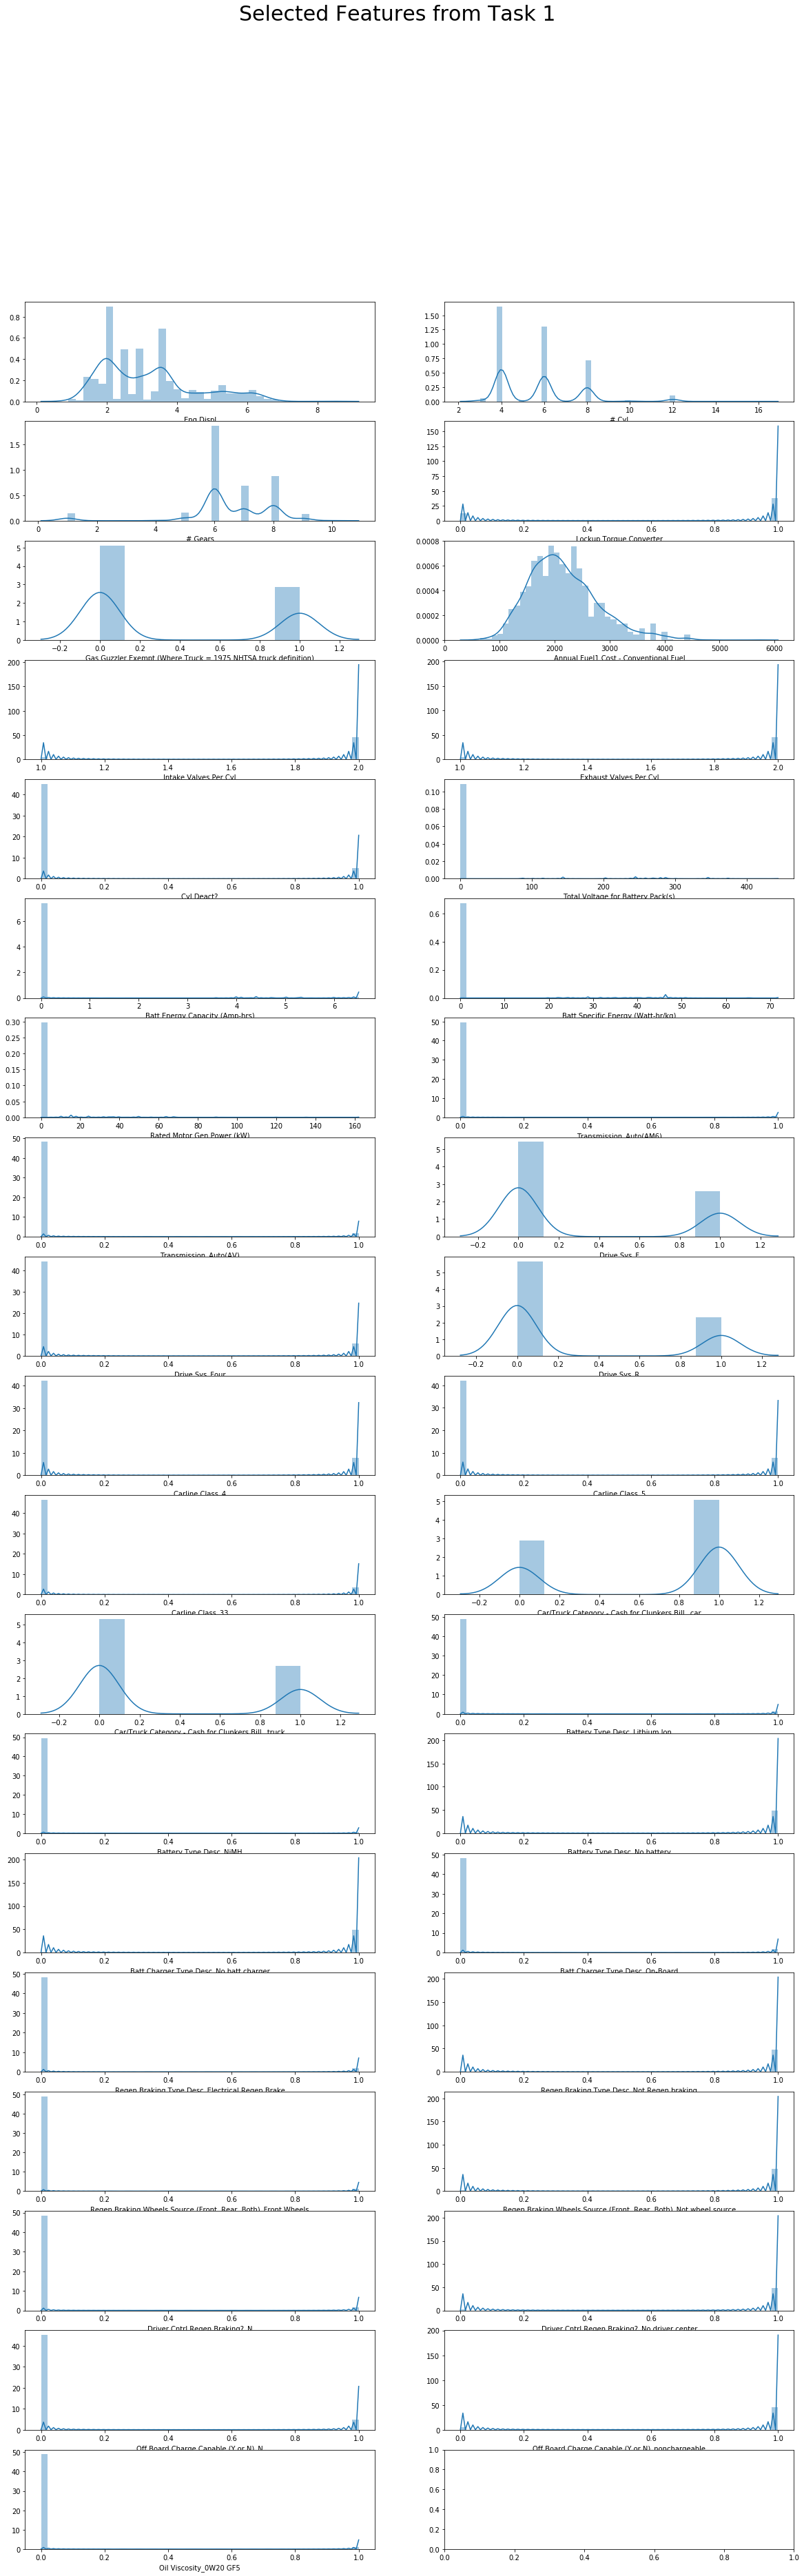

In [32]:
fig, axes = plt.subplots(19,2,figsize=(20,60))
k=0
for i in range(19):
    for j in range(2):
        sns.distplot(X_train[list(X_train)[k]],ax=axes[i,j])
        k+=1
        if k==37:
            break
        
plt.suptitle("Selected Features from Task 1", fontsize=30)

#### Next see whether a standard scalar would help, almost unchanged

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
lr = LinearRegression().fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
lr.score(X_test_scaled, y_test)

0.86517944810366021

#### Since the data is quite sparse, MaxAbsScaler maybe work, but almost unchanged

In [30]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
lr = LinearRegression().fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
lr.score(X_test_scaled, y_test)

0.86517944810366088

#### Try the polynomial feature engineering, it doesn't work

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_lr = make_pipeline(PolynomialFeatures(include_bias=False),LinearRegression())
poly_lr.fit(X_train,y_train)
print("accuracy: {:.2f}".format(poly_lr.score(X_test, y_test)))

accuracy: -5275868824.31


## Task 3 Try other models

We first try SVR

In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
svr = SVR()
#print(np.mean(cross_val_score(SVC(), X_train, y_train, cv=10)))
#print(np.mean(cross_val_score(scaled_svc, X_train, y_train, cv=10)))

svr.fit(X_train,y_train)
print("accuracy: {:.2f}".format(svr.score(X_test, y_test)))

accuracy: 0.53


The result is very bad. Then we scale the data to see if performance increased

In [33]:
scaled_svr=make_pipeline(StandardScaler(), SVR())
scaled_svr.fit(X_train,y_train)
print("accuracy: {:.2f}".format(scaled_svr.score(X_test, y_test)))

accuracy: 0.83


The result increased a lot, however still not very promising, we will try if feature selection with lasso helps

In [34]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
lasso = LassoCV().fit(X_train_scaled, y_train)
print(lasso.coef_)
select_lassocv = SelectFromModel(LassoCV(), threshold=1e-5)
select_lassocv.fit(X_train, y_train)
print(select_lassocv.transform(X_train).shape)
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, SVR())
np.mean(cross_val_score(pipe_lassocv, X_train, y_train, cv=10))



[ -2.42780537e+00  -2.69888333e-01   1.58020886e-01  -0.00000000e+00
   0.00000000e+00  -1.57946711e+00  -2.18003448e-01  -3.37065723e-01
   7.68941058e-02   0.00000000e+00   0.00000000e+00   9.99721087e-01
   1.71115463e-01   3.00336818e-01   6.35024039e-01   8.94529074e-01
   1.15236970e-01   9.20454839e-02   2.47775619e-01   1.12235780e-01
   5.93286433e-03   1.57433476e+00   6.06863776e-01  -2.14751459e-01
  -0.00000000e+00   1.21067453e-01   2.28531625e-14   0.00000000e+00
   2.11259093e-01   1.89600723e-01   6.15953346e-01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   8.39213067e-02  -0.00000000e+00
   4.05601914e-01]
(3694L, 1L)


0.81242521111592647

Feature selection does not help, so we start with something new instead of getting stuck here to get minor improved for svr

we will try to use decision tree

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
svr = DecisionTreeRegressor()
svr.fit(X_train,y_train)
print("Accuracy: {:.3f}".format(svr.score(X_test, y_test)))

Accuracy: 0.937


### Task 4  

The result is much better and we want to check if results can be further improved with feature selection

In [42]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
lasso = LassoCV().fit(X_train_scaled, y_train)
print(lasso.coef_)
select_lassocv = SelectFromModel(LassoCV(), threshold=1e-5)
select_lassocv.fit(X_train, y_train)
print(select_lassocv.transform(X_train).shape)
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, DecisionTreeRegressor())

pipe_lassocv.fit(X_train,y_train)
print("test accuracy: {:.3f}".format(pipe_lassocv.score(X_test, y_test)))

[ -2.42780537e+00  -2.69888333e-01   1.58020886e-01  -0.00000000e+00
   0.00000000e+00  -1.57946711e+00  -2.18003448e-01  -3.37065723e-01
   7.68941058e-02   0.00000000e+00   0.00000000e+00   9.99721087e-01
   1.71115463e-01   3.00336818e-01   6.35024039e-01   8.94529074e-01
   1.15236970e-01   9.20454839e-02   2.47775619e-01   1.12235780e-01
   5.93286433e-03   1.57433476e+00   6.06863776e-01  -2.14751459e-01
  -0.00000000e+00   1.21067453e-01   2.28531625e-14   0.00000000e+00
   2.11259093e-01   1.89600723e-01   6.15953346e-01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   8.39213067e-02  -0.00000000e+00
   4.05601914e-01]
(3694L, 1L)
test accuracy: 0.937


We did not see a huge improvement, but the model now is much simpler without any compromise in accuracy.

Since decision tree performs so well, it is natural to try random forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train,y_train)
print("Accuracy: {:.2f}".format(rf.score(X_test, y_test)))

Accuracy: 0.96


It did very well and let's see how can we make it even better

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, 50)}
grid = GridSearchCV(RandomForestRegressor(n_estimators=200,random_state=0),param_grid=param_grid,
                    cv=10)
grid.fit(X_train, y_train)
grid.score(X_test,y_test)

0.94181496608947013

Turning the depth does not really help

### Then we further release the feature selection threshold  to where crrelation with y_train > 0.03,  and use the random forest model. We conclude this as our final model.

In [48]:
df_train = df_total[df_total['Model Year']!=2018]
df_test = df_total[df_total['Model Year']==2018]
X_train = df_train.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_train = df_train['Comb Unrd Adj FE - Conventional Fuel']
X_test = df_test.drop(['Comb Unrd Adj FE - Conventional Fuel'],axis=1)
y_test = df_test['Comb Unrd Adj FE - Conventional Fuel']

In [49]:
# Deal with
important_features = []
for i in list(X_train):
    if abs(y_train.corr(X_train[i]))>0.03:
        important_features.append(i)
X_train=X_train[important_features]
X_test=X_test[important_features]

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train,y_train)
print('Accuracy:',rf.score(X_test, y_test))

('Accuracy:', 0.98365690758924373)
